In [1]:
import numpy as np 
import pandas as pd 

import lightgbm as lgb

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_recall_curve, roc_curve
import warnings
from sklearn.preprocessing import LabelEncoder
import gc
import os
import time
import sys
import datetime
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
from sklearn import metrics
from sklearn.metrics import roc_auc_score

# 新增可视化相关库
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set(font_scale=1.2)

In [2]:
# 设置中文字体，解决乱码问题
plt.rcParams["font.family"] = ["SimHei", "WenQuanYi Micro Hei", "Heiti TC"]
sns.set(font='SimHei', font_scale=0.8)  # 解决seaborn中文显示问题

In [3]:
train = pd.read_csv('../data/train.csv')
label = pd.read_csv('../data/train_label.csv')
test = pd.read_csv('../data/test.csv')
sub = pd.read_csv('../data/submission.csv')

#  特征工程

In [4]:
df_source = train.merge(label,on='ID',how='left')


test['label'] = -1
train = train.merge(label,on='ID',how='left')
data = pd.concat([train, test])


In [5]:


#提取时间特征

def get_time_fe(df):
    df['day'] = df.date.apply(lambda x:int(x[8:10]))
    df['hour'] = df.date.apply(lambda x:int(x[11:13]))
    return df





#对时间分箱
def getSeg(x):
    if x >=0 and x<= 3:
        return 1
    elif x>=4 and x<=12:
        return 2
    elif x>=13 and x<=18:
        return 3
    elif x>=19 and x<=23:
        return 1




#count统计特征
cross_feature = []
def get_cross_fe(df):
    first_feature = [ 'B2', 'B3']
    second_feature = ['C1','C2','C3','D1','A1','A2','A3']
    for feat_1 in first_feature:
        for feat_2 in second_feature:
            col_name = "cross_" + feat_1 + "_and_" + feat_2
            cross_feature.append(col_name)
            df[col_name] = df[feat_1].astype(str).values + '_' + df[feat_2].astype(str).values
    return df



#获取nunique特征
def get_nunique_1_fe(df):
    adid_nuq = [ 'hour','E1','E14','B2','B3']
    for feat in adid_nuq:
        gp1 = df.groupby('A2')[feat].nunique().reset_index().rename(columns={feat: "A2_%s_nuq_num" % feat})
        gp2 = df.groupby(feat)['A2'].nunique().reset_index().rename(columns={'A2': "%s_A2_nuq_num" % feat})
        df = pd.merge(df, gp1, how='left', on=['A2'])
        df = pd.merge(df, gp2, how='left', on=[feat])
    return df
def get_nunique_2_fe(df):
    adid_nuq = [ 'E1','E14']
    for feat in adid_nuq:
        gp1 = df.groupby('hour')[feat].nunique().reset_index().rename(columns={feat: "hour_%s_nuq_num" % feat})
        gp2 = df.groupby(feat)['hour'].nunique().reset_index().rename(columns={'hour': "%s_hour_nuq_num" % feat})
        df = pd.merge(df, gp1, how='left', on=['hour'])
        df = pd.merge(df, gp2, how='left', on=[feat])
    return df

# def get_nunique_3_fe(df):
#     adid_nuq = ['B2','B3']
#     for feat in adid_nuq:
#         gp1 = df.groupby('A3')[feat].nunique().reset_index().rename(columns={feat: "A3_%s_nuq_num" % feat})
#         gp2 = df.groupby(feat)['A3'].nunique().reset_index().rename(columns={'A3': "%s_A3_nuq_num" % feat})
#         df = pd.merge(df, gp1, how='left', on=['A3'])
#         df = pd.merge(df, gp2, how='left', on=[feat])
#     return df

def get_nunique_4_fe(df):
    adid_nuq = [ 'B2','B3']
    for feat in adid_nuq:
        gp1 = df.groupby('A1')[feat].nunique().reset_index().rename(columns={feat: "A1_%s_nuq_num" % feat})
        gp2 = df.groupby(feat)['A1'].nunique().reset_index().rename(columns={'A1': "%s_A1_nuq_num" % feat})
        df = pd.merge(df, gp1, how='left', on=['A1'])
        df = pd.merge(df, gp2, how='left', on=[feat])
    return df




data = get_time_fe(data)
# data['hour_seg'] = data['hour'].apply(lambda x: getSeg(x))
data = get_cross_fe(data)
data = get_nunique_1_fe(data)
data = get_nunique_2_fe(data)
# data = get_nunique_3_fe(data)
# data = get_nunique_4_fe(data)



len(cross_feature)




#labelencoder()
cate_feature = ['A1','A2','A3','B1','B2','B3','C1','C2','C3','E2','E3','E5','E7','E9','E10','E13','E16','E17','E19','E21','E22']
# cross_feature = cross_feature[:15]
cate_features = cate_feature+cross_feature
for item in cate_features:
    data[item] = LabelEncoder().fit_transform(data[item])


# In[14]:


def feature_count(data, features=[]):
    new_feature = 'count'
    for i in features:
        new_feature += '_' + i
    try:
        del data[new_feature]
    except:
        pass
    temp = data.groupby(features).size().reset_index().rename(columns={0: new_feature})
    data = data.merge(temp, 'left', on=features)
    return data

for i in cross_feature:
    n = data[i].nunique()
    if n > 5:
        data = feature_count(data, [i])
    else:
        print(i, ':', n)


# In[15]:


#ratio：类别偏好的ratio比例特征
label_feature =[ 'A2', 'A3','hour']
data_temp = data[label_feature]
df_feature = pd.DataFrame()
data_temp['cnt'] = 1
print('Begin ratio clcik...')
col_type = label_feature.copy()
n = len(col_type)
for i in range(n):
    col_name = "ratio_click_of_" + col_type[i]
    df_feature[col_name] = (
                    data_temp[col_type[i]].map(data_temp[col_type[i]].value_counts()) / len(data) * 100).astype(int)            
data = pd.concat([data, df_feature], axis=1)
print('The end')




train_df = data[data['label'] != -1]
test_df = data[data['label'] == -1]



Begin ratio clcik...
The end


绘制特征相关性热图...


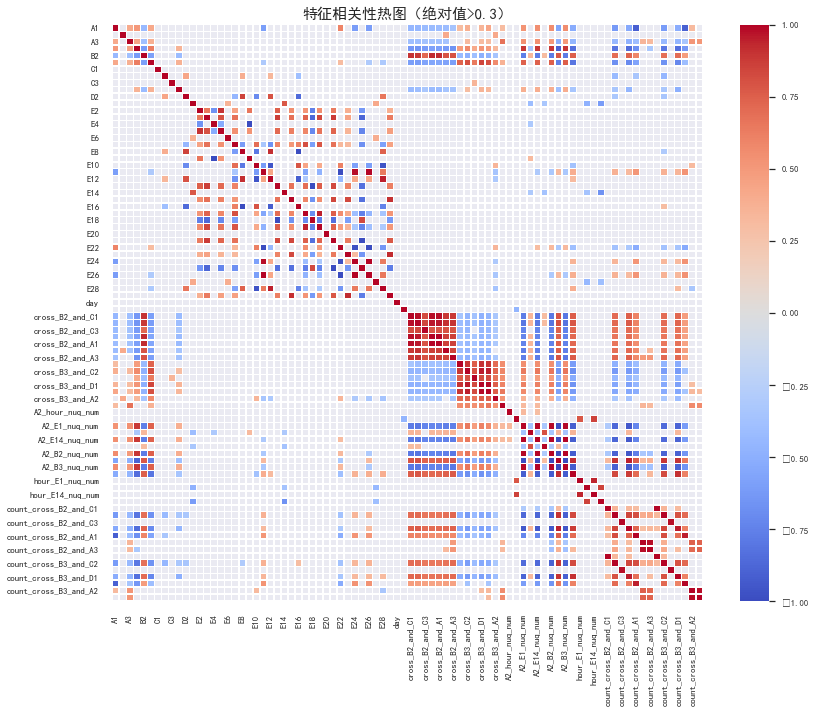

In [6]:
# 特征相关性热图
print("绘制特征相关性热图...")
# 选择数值型特征计算相关性
numeric_features = train_df.select_dtypes(include=['int64', 'float64']).columns
# 排除ID和标签列
numeric_features = [f for f in numeric_features if f not in ['ID', 'label']]
if len(numeric_features) > 0:
    corr_matrix = train_df[numeric_features].corr()
    # 绘制热图（只显示绝对值大于0.3的相关性）
    plt.figure(figsize=(12, 10))
    mask = np.abs(corr_matrix) < 0.3  # 掩盖低相关性
    sns.heatmap(
        corr_matrix, 
        mask=mask, 
        annot=False,  # 显示相关系数
        cmap='coolwarm', 
        fmt='.2f', 
        linewidths=0.5,
        annot_kws={"size": 8}
    )
    plt.title('特征相关性热图（绝对值>0.3）', fontsize=15)
    plt.tight_layout()
    plt.show()
else:
    print("无可用的数值型特征用于绘制相关性热图")


In [7]:
# # 删除不需要的字段
from sklearn.model_selection import train_test_split, StratifiedKFold
## get train feature
del_feature = ['ID','day','date','label','D2']+cross_feature
features = [i for i in train_df.columns if i not in del_feature]




train_x = train_df[features]
train_y = train_df['label'].values
test = test_df[features]





# 设置随机种子，保证结果可复现
np.random.seed(42)

# 假设train_x（DataFrame或数组）和train_y（Series或数组）是已有的训练数据
# 请确保在实际使用时已经正确加载了这两个变量

# 确保train_y是一维数组
if isinstance(train_y, pd.Series):
    train_y = train_y.values

# 获取特征数量和特征名称
if isinstance(train_x, pd.DataFrame):
    n_features = train_x.shape[1]
    feature_names = train_x.columns.tolist()
else:
    n_features = train_x.shape[1]
    feature_names = [f'特征{i+1}' for i in range(n_features)]




# 1. 定义多组不同的LightGBM参数配置

In [9]:
def get_lgb_param_sets():
    """返回多组不同的LightGBM参数配置"""
    return [
        # 第一组参数：默认参数
        {
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': 'auc',
            'learning_rate': 0.05,
            'num_leaves': 31,
            'max_depth': -1,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'verbose': 0,
            'seed': 42,
            'n_jobs': -1
        },
        # 第二组参数：更深的树和更多叶子
        {
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': 'auc',
            'learning_rate': 0.03,
            'num_leaves': 63,
            'max_depth': 8,
            'feature_fraction': 0.7,
            'bagging_fraction': 0.7,
            'bagging_freq': 3,
            'verbose': 0,
            'seed': 43,
            'n_jobs': -1
        },
        # 第三组参数：更高的学习率和不同的采样策略
        {
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': 'auc',
            'learning_rate': 0.1,
            'num_leaves': 25,
            'max_depth': 6,
            'feature_fraction': 0.9,
            'bagging_fraction': 0.9,
            'bagging_freq': 7,
            'verbose': 0,
            'seed': 44,
            'n_jobs': -1
        } ,
        # 第四组参数：使用dart boosting类型
        {
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': 'auc',
            'learning_rate': 0.05,
            'num_leaves': 31,
            'max_depth': -1,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'drop_rate': 0.1,
            'verbose': 0,
            'seed': 45,
            'n_jobs': -1
        }

    ]




# 2. 实现stacking（使用不同参数的基模型）

In [10]:
def stacking_lgb(X, y):
    # 获取多组参数配置
    param_sets = get_lgb_param_sets()
    print(f"将使用{len(param_sets)}个不同参数配置的LightGBM模型作为基模型")
    
    # 初始化模型列表
    models = []
    # 创建K折交叉验证（用于每个基模型的训练）
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # 训练不同参数的基模型
    print("开始训练基模型...")
    for i, params in enumerate(param_sets, 1):
        # 对每个参数配置，使用K折交叉验证训练一个模型
        # 这里使用最后一折的模型作为基模型，也可以使用所有折的平均
        for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
            # 处理DataFrame的索引问题
            if isinstance(X, pd.DataFrame):
                X_train = X.iloc[train_idx]
                X_val = X.iloc[val_idx]
            else:
                X_train = X[train_idx]
                X_val = X[val_idx]
            
            y_train, y_val = y[train_idx], y[val_idx]
            
            # 创建LightGBM数据集
            lgb_train = lgb.Dataset(X_train, y_train)
            lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)
            
            # 训练模型
            model = lgb.train(
                params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=[lgb_train, lgb_val],
                valid_names=['train', 'valid'],
                early_stopping_rounds=50,
                verbose_eval=0  # 关闭单个折的日志输出
            )
            
            # 只保留最后一折的模型作为该参数配置的代表
            if fold == kf.n_splits - 1:
                models.append(model)
                
                # 评估该模型
                y_pred = model.predict(X_val, num_iteration=model.best_iteration)
                auc = roc_auc_score(y_val, y_pred)
                print(f"基模型 {i}（参数配置 {i}）验证集AUC: {auc:.4f}")
                break
    
    # 生成元特征（第二层的输入）
    print("\n生成元特征...")
    meta_features = np.zeros((X.shape[0], len(models)))
    for i, model in enumerate(models):
        meta_features[:, i] = model.predict(X, num_iteration=model.best_iteration)
    
    # 第二层模型训练（使用元特征）
    print("\n开始训练元模型...")
    # 元模型使用一组单独的参数
    meta_params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.05,
        'num_leaves': 15,  # 元特征较少，使用较简单的模型
        'max_depth': 3,
        'verbose': 0,
        'seed': 42,
        'n_jobs': -1
    }
    
    lgb_meta_train = lgb.Dataset(meta_features, y)
    meta_model = lgb.train(
        meta_params,
        lgb_meta_train,
        num_boost_round=1000,
        valid_sets=[lgb_meta_train],
        early_stopping_rounds=50,
        verbose_eval=100
    )
    
    return models, meta_model, param_sets

# 3. 训练stacking模型

In [11]:
models, meta_model, param_sets = stacking_lgb(train_x, train_y)

将使用4个不同参数配置的LightGBM模型作为基模型
开始训练基模型...
基模型 1（参数配置 1）验证集AUC: 0.7271
基模型 2（参数配置 2）验证集AUC: 0.7302
基模型 3（参数配置 3）验证集AUC: 0.7275
基模型 4（参数配置 4）验证集AUC: 0.7278

生成元特征...

开始训练元模型...
Training until validation scores don't improve for 50 rounds
[100]	training's auc: 0.830131
[200]	training's auc: 0.834882
[300]	training's auc: 0.83741
[400]	training's auc: 0.839016
[500]	training's auc: 0.840276
[600]	training's auc: 0.8416
[700]	training's auc: 0.842726
[800]	training's auc: 0.843787
[900]	training's auc: 0.844914
[1000]	training's auc: 0.846083
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 0.846083


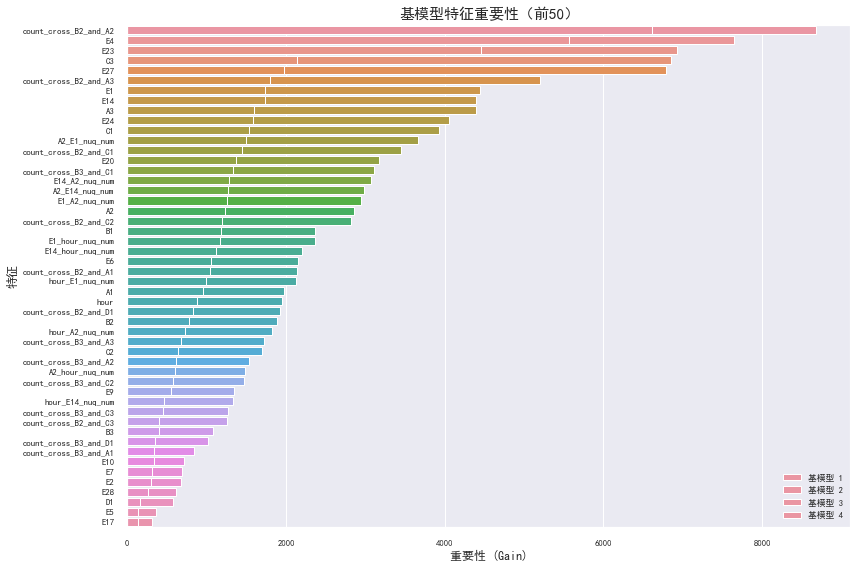

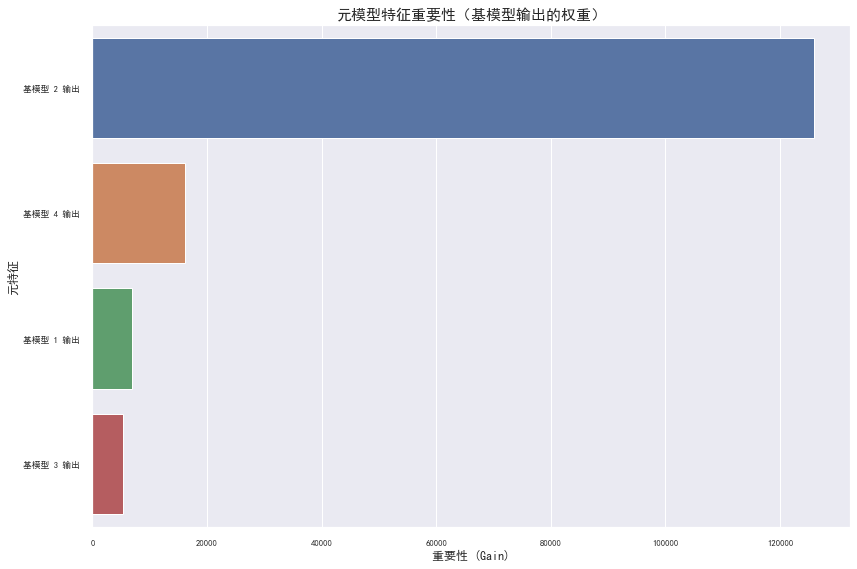

In [19]:
# 定义特征重要性可视化函数
def plot_feature_importance(models, feature_names, top_n=50, figsize=(12, 8)):
    """
    可视化基模型和元模型的特征重要性
    
    models: 基模型列表
    feature_names: 特征名称列表
    top_n: 显示前N个重要特征
    figsize: 图表大小
    """
    # 基模型特征重要性
    plt.figure(figsize=figsize)
    for i, model in enumerate(models):
        importance = model.feature_importance(importance_type='gain')
        feat_imp = pd.DataFrame({
            'feature': feature_names,
            'importance': importance,
            'model': f'基模型 {i+1}'
        })
        # 取前N个重要特征
        top_feat = feat_imp.sort_values('importance', ascending=False).head(top_n)
        sns.barplot(x='importance', y='feature', data=top_feat, label=f'基模型 {i+1}')
        
        
    
    plt.title(f'基模型特征重要性（前{top_n}）', fontsize=15)
    plt.xlabel('重要性 (Gain)', fontsize=12)
    plt.ylabel('特征', fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    
    
    
    
    # 元模型特征重要性（元特征对应基模型的预测结果）
    plt.figure(figsize=figsize)
    meta_importance = meta_model.feature_importance(importance_type='gain')
    meta_feat_imp = pd.DataFrame({
        'feature': [f'基模型 {i+1} 输出' for i in range(len(models))],
        'importance': meta_importance
    })
    meta_feat_imp = meta_feat_imp.sort_values('importance', ascending=False)
    
    sns.barplot(x='importance', y='feature', data=meta_feat_imp)
    plt.title('元模型特征重要性（基模型输出的权重）', fontsize=15)
    plt.xlabel('重要性 (Gain)', fontsize=12)
    plt.ylabel('元特征', fontsize=12)
    plt.tight_layout()
    plt.show()

# 绘制特征重要性
plot_feature_importance(models, features)


# 多指标评估及可视化


交叉验证评估结果与可视化...
最终Stacking模型的平均AUC: 0.8455 ± 0.0533
最终Stacking模型的平均KS: 0.5289 ± 0.0846
最终Stacking模型的平均最佳F1: 0.5421 ± 0.0705


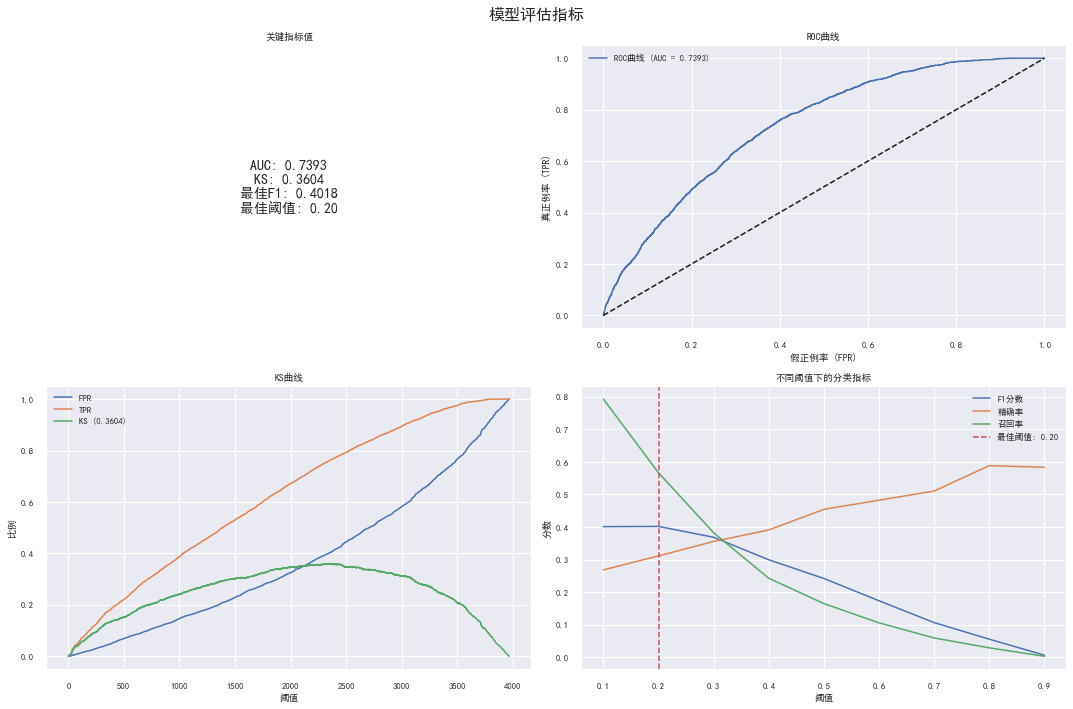

In [13]:
# 定义多指标计算函数
def calculate_metrics(y_true, y_pred_proba):
    """计算多个评估指标"""
    # 计算AUC
    auc = roc_auc_score(y_true, y_pred_proba)
    
    # 计算KS
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    ks = max(tpr - fpr)
    
    # 计算不同阈值下的F1、精确率、召回率
    thresholds = np.arange(0.1, 1.0, 0.1)
    f1_scores = []
    precision_scores = []
    recall_scores = []
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        f1_scores.append(f1_score(y_true, y_pred))
        precision_scores.append(precision_score(y_true, y_pred))
        recall_scores.append(recall_score(y_true, y_pred))
    
    # 找到最佳F1对应的阈值
    best_f1_idx = np.argmax(f1_scores)
    best_f1 = f1_scores[best_f1_idx]
    best_threshold = thresholds[best_f1_idx]
    
    return {
        'auc': auc,
        'ks': ks,
        'best_f1': best_f1,
        'best_threshold': best_threshold,
        'thresholds': thresholds,
        'f1_scores': f1_scores,
        'precision_scores': precision_scores,
        'recall_scores': recall_scores
    }

# 定义评估指标可视化函数
def plot_metrics(metrics, figsize=(15, 10)):
    """可视化评估指标"""
    # 创建画布
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle('模型评估指标', fontsize=16)
    
    # 1. AUC和KS值展示
    ax1 = axes[0, 0]
    metrics_text = f"AUC: {metrics['auc']:.4f}\nKS: {metrics['ks']:.4f}\n最佳F1: {metrics['best_f1']:.4f}\n最佳阈值: {metrics['best_threshold']:.2f}"
    ax1.text(0.5, 0.5, metrics_text, fontsize=14, ha='center', va='center')
    ax1.set_title('关键指标值')
    ax1.axis('off')
    
    # 2. ROC曲线
    ax2 = axes[0, 1]
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
    ax2.plot(fpr, tpr, label=f'ROC曲线 (AUC = {metrics["auc"]:.4f})')
    ax2.plot([0, 1], [0, 1], 'k--')  # 随机猜测的基准线
    ax2.set_xlabel('假正例率 (FPR)')
    ax2.set_ylabel('真正例率 (TPR)')
    ax2.set_title('ROC曲线')
    ax2.legend()
    
    # 3. KS曲线
    ax3 = axes[1, 0]
    ax3.plot(fpr, label='FPR')
    ax3.plot(tpr, label='TPR')
    ax3.plot(tpr - fpr, label=f'KS ({metrics["ks"]:.4f})')
    ax3.set_xlabel('阈值')
    ax3.set_ylabel('比例')
    ax3.set_title('KS曲线')
    ax3.legend()
    
    # 4. F1、精确率、召回率随阈值变化
    ax4 = axes[1, 1]
    ax4.plot(metrics['thresholds'], metrics['f1_scores'], label='F1分数')
    ax4.plot(metrics['thresholds'], metrics['precision_scores'], label='精确率')
    ax4.plot(metrics['thresholds'], metrics['recall_scores'], label='召回率')
    ax4.axvline(x=metrics['best_threshold'], color='r', linestyle='--', label=f'最佳阈值: {metrics["best_threshold"]:.2f}')
    ax4.set_xlabel('阈值')
    ax4.set_ylabel('分数')
    ax4.set_title('不同阈值下的分类指标')
    ax4.legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # 为suptitle留出空间
    plt.show()


# # 模型评估与可视化


print("\n交叉验证评估结果与可视化...")
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
final_auc_scores = []
final_ks_scores = []
final_f1_scores = []

# 保存最后一折的预测结果用于可视化
y_val = None
y_pred_proba = None

for fold, (train_idx, val_idx) in enumerate(kf.split(train_x, train_y)):
    # 为验证集生成元特征
    val_meta_features = np.zeros((len(val_idx), len(models)))
    
    # 处理DataFrame的索引问题
    if isinstance(train_x, pd.DataFrame):
        X_val = train_x.iloc[val_idx]
    else:
        X_val = train_x[val_idx]
    
    for i, model in enumerate(models):
        val_meta_features[:, i] = model.predict(X_val, num_iteration=model.best_iteration)
    
    # 使用元模型预测
    y_pred = meta_model.predict(val_meta_features, num_iteration=meta_model.best_iteration)
    auc = roc_auc_score(train_y[val_idx], y_pred)
    
    # 计算其他指标
    metrics = calculate_metrics(train_y[val_idx], y_pred)
    
    final_auc_scores.append(auc)
    final_ks_scores.append(metrics['ks'])
    final_f1_scores.append(metrics['best_f1'])
    
    # 保存最后一折的结果用于可视化
    if fold == kf.n_splits - 1:
        y_val = train_y[val_idx]
        y_pred_proba = y_pred
        fold_metrics = metrics

print(f"最终Stacking模型的平均AUC: {np.mean(final_auc_scores):.4f} ± {np.std(final_auc_scores):.4f}")
print(f"最终Stacking模型的平均KS: {np.mean(final_ks_scores):.4f} ± {np.std(final_ks_scores):.4f}")
print(f"最终Stacking模型的平均最佳F1: {np.mean(final_f1_scores):.4f} ± {np.std(final_f1_scores):.4f}")

# 绘制最后一折的评估指标可视化
plot_metrics(fold_metrics)

# 5. 保存模型为pkl文件

In [14]:
print("\n保存模型...")
# 将基础模型、元模型和参数配置一起保存
stacking_model = {
    'base_models': models,
    'meta_model': meta_model,
    'param_sets': param_sets  # 保存参数配置，方便后续查看
}

# 保存到pkl文件
with open('./models/stacking_model_with_params.pkl', 'wb') as f:
    pickle.dump(stacking_model, f)

print("模型已保存为 stacking_model_with_params.pkl")


保存模型...
模型已保存为 stacking_model_with_params.pkl


#  6. 加载模型并进行预测

In [15]:

def predict_with_model(model_path, X):
    """
    使用保存的stacking模型进行预测
    
    model_path: 模型pkl文件路径
    X: 待预测的特征数据（DataFrame或数组）
    
    返回:
    预测概率
    """
    # 加载模型
    with open(model_path, 'rb') as f:
        stacking_model = pickle.load(f)
    
    base_models = stacking_model['base_models']
    meta_model = stacking_model['meta_model']
    
    # 生成元特征
    meta_features = np.zeros((X.shape[0], len(base_models)))
    for i, model in enumerate(base_models):
        meta_features[:, i] = model.predict(X, num_iteration=model.best_iteration)
    
    # 元模型预测
    predictions = meta_model.predict(meta_features, num_iteration=meta_model.best_iteration)
    
    return predictions




test_x = test
predictions = predict_with_model('./models/stacking_model_with_params.pkl', test_x)
sub['lable'] = predictions
sub.to_csv('./sub/stacking_model_with_params.csv',index  = False)
print("预测结果:", predictions)

预测结果: [0.41785103 0.10262235 0.27112868 ... 0.26547399 0.04331196 0.18046277]
